In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [3]:
import torchvision.utils

In [4]:
import torch
import torch.nn as nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [5]:
from collections import defaultdict
import torch.nn.functional as F
import torch
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics, bce_weight=0.5)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [7]:
from PIL import Image
class Dataset(object):
    def __init__(self, datapath):
        # load paths for your dataset and put in self.data
        self.datapath = datapath
        self.maskpath = '../masks'
        self.data = []
        self.masks = []
        for folder in os.listdir(datapath):
            for filename in os.listdir(datapath+'/'+folder):
                self.data.append(folder+'/'+filename)
                self.masks.append(filename.split('.')[0])
            
            
    def __getitem__(self, idx):
        im_dim = 224 #672
        
        # load images
        image = Image.open(self.datapath + '/' +  self.data[idx]).convert("RGB").resize((im_dim,im_dim))
        image_size = (image.size[0], image.size[1], 3)
        image = np.array(image.getdata()).reshape(image_size)
        maskname = self.maskpath + '/' +  self.masks[idx] + '_mask.jpg'

        if self.masks[idx] + '_mask.jpg' in os.listdir(self.maskpath):
            mask = np.array(Image.open(maskname).convert("RGB").resize((im_dim,im_dim)).getdata())
        elif self.masks[idx] + '_mask0.jpg' in os.listdir(self.maskpath):
            i = 0
            mask = np.zeros(image_size).reshape([-1,3])
            while self.masks[idx] + '_mask' + str(i) + '.jpg' in os.listdir(self.maskpath):
                maskname = self.maskpath + '/' +  self.masks[idx] + '_mask' + str(i) + '.jpg'
                mask_ = np.array(Image.open(maskname).convert("RGB").resize((im_dim,im_dim)).getdata())
                mask = mask + mask_ # can add since masks should not overlap
                i += 1
        else:
            raise Exception("MISSING MASK for " + self.masks[idx])

        mask = mask.reshape(image_size)
        mask = mask.mean(axis=2)
        #mask = mask.reshape([1,image_size[0], image_size[1]])
        
        mask = np.stack([mask,mask],axis=0)
        mask[1] = 255-mask[1]
        
        
        image = image.transpose([2,0,1])
        #image /= 255
        mask /= 255
        
        #two size options were reshaped to (672,672,3)
        #(1680, 1050, 3)
        #(640, 480, 3)
        
        
        return torch.Tensor(image), torch.Tensor(mask)

    def __len__(self):
        return len(self.data)

In [8]:
data_dir = '../dataset'
image_datasets = {x: Dataset(os.path.join(data_dir, x))
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp /= 255
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def imshowimagemasked(img, mask, title=None):
    """Imshow for Tensor."""
    inp = img
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.imshow(mask.numpy(), alpha=.2) #,cmap='jet',alpha=0.2)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_segmenter(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            #preds = 1*(outputs>.5)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//2, 2, images_so_far)
                #ax.axis('off')
                imshow(inputs.cpu().data[j])
                imshowimagemasked(inputs.cpu().data[j], preds.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 2

model = ResNetUNet(num_class).to(device)

# freeze backbone layers
# Comment out to finetune further
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        


cuda:0


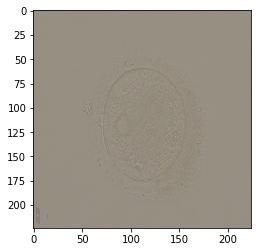

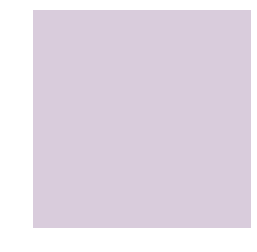

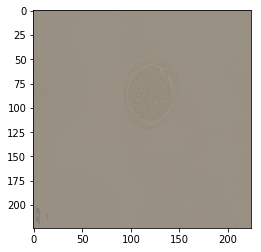

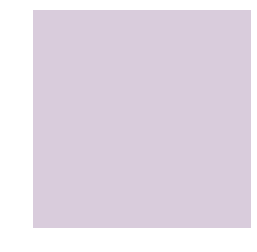

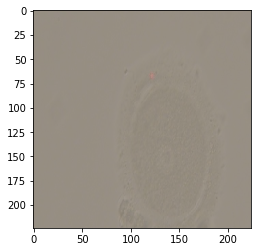

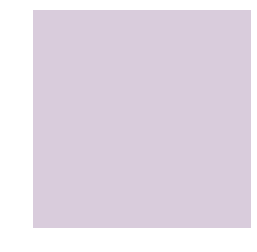

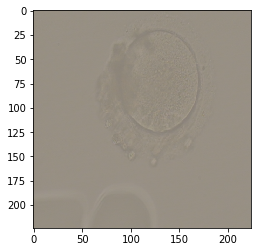

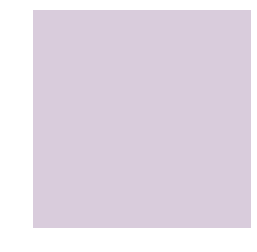

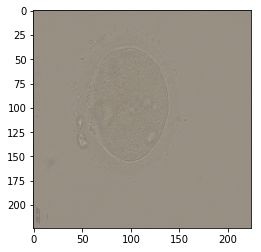

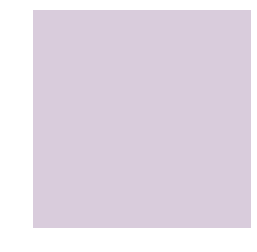

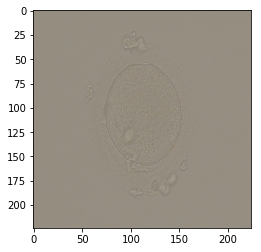

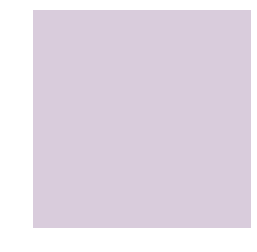

In [13]:
visualize_segmenter(model)

In [15]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
LR 0.0001
train: bce: 0.217538, dice: 0.192110, loss: 0.204824
val: bce: 0.105918, dice: 0.101989, loss: 0.103954
saving best model
0m 51s
Best val loss: 0.103954


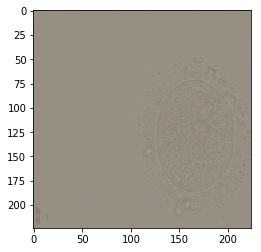

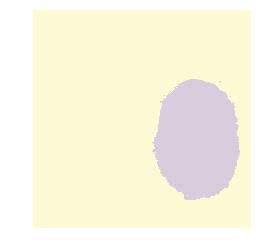

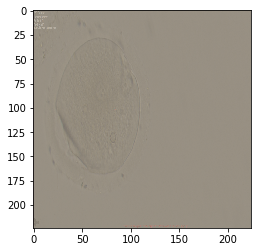

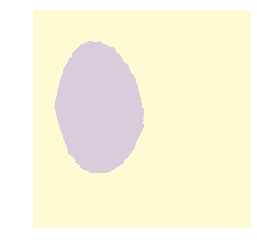

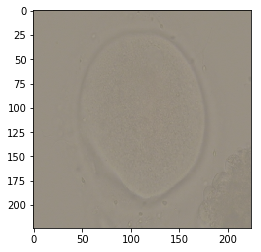

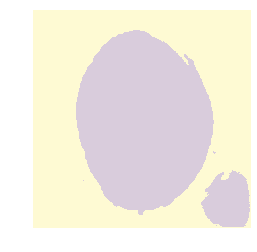

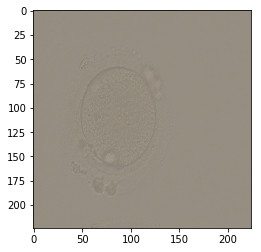

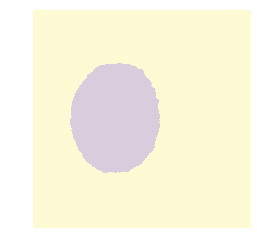

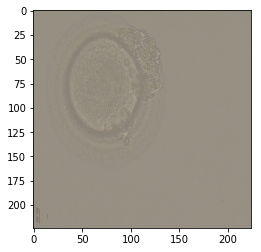

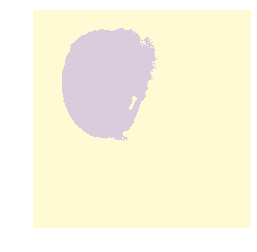

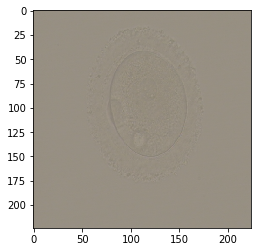

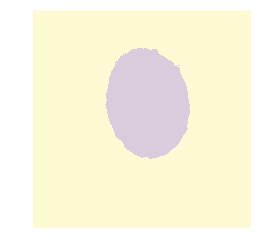

In [16]:
visualize_segmenter(model)

In [17]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
LR 0.0001
train: bce: 0.101157, dice: 0.085757, loss: 0.093457
val: bce: 0.110177, dice: 0.090057, loss: 0.100117
saving best model
0m 50s
Epoch 1/4
----------
LR 0.0001
train: bce: 0.083555, dice: 0.072583, loss: 0.078069
val: bce: 0.079098, dice: 0.074068, loss: 0.076583
saving best model
0m 51s
Epoch 2/4
----------
LR 0.0001
train: bce: 0.078694, dice: 0.065846, loss: 0.072270
val: bce: 0.079162, dice: 0.071529, loss: 0.075346
saving best model
0m 51s
Epoch 3/4
----------
LR 0.0001
train: bce: 0.069944, dice: 0.060427, loss: 0.065186
val: bce: 0.072050, dice: 0.066394, loss: 0.069222
saving best model
0m 51s
Epoch 4/4
----------
LR 0.0001
train: bce: 0.062821, dice: 0.054008, loss: 0.058414
val: bce: 0.076663, dice: 0.061220, loss: 0.068941
saving best model
0m 51s
Best val loss: 0.068941


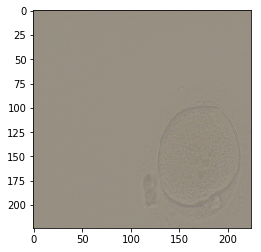

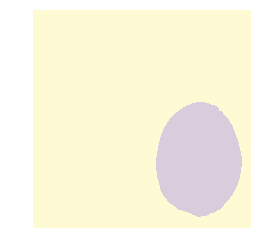

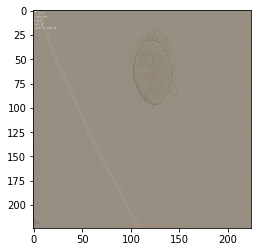

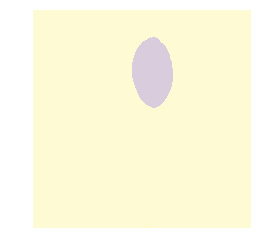

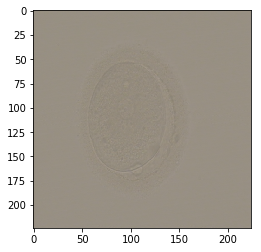

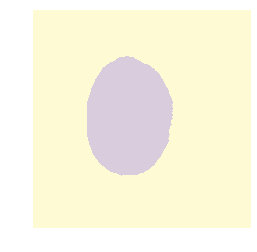

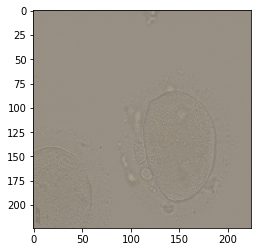

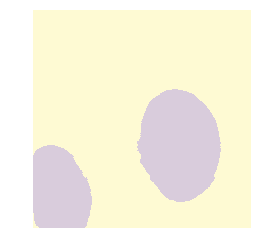

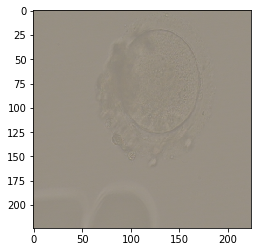

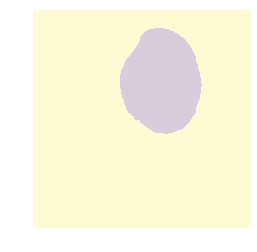

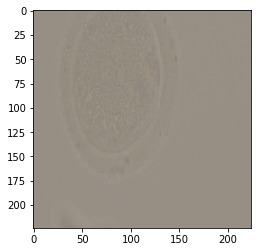

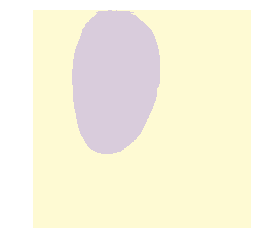

In [18]:
visualize_segmenter(model)

In [ ]:
0/0

In [ ]:
data_dir = '../dataset'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation((-45, 45)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(), 
        transforms.ToTensor(),
        transforms.ColorJitter(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

raw_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
rawdataloaders = {x: torch.utils.data.DataLoader(raw_image_datasets[x], batch_size=4, 
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [ ]:
def imshow_hack(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
 

def imshowimagemasked_hack(img, mask, title=None):
    """Imshow for Tensor."""
    inp = img
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.imshow(mask.numpy()[0],cmap='jet',alpha=0.2)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
 


def visualize_segmenter_other(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(rawdataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            #_, preds = torch.max(outputs, 1)
            preds = 1*(outputs>.5)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//2, 2, images_so_far)
                #ax.axis('off')
                imshow_hack(inputs.cpu().data[j])
                imshowimagemasked_hack(inputs.cpu().data[j], preds.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_segmenter_other(model)